<a href="https://colab.research.google.com/github/eshikapathak/Personalized-Federated-Learning/blob/main/Basic/FedAvg_and_FedSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedAvg

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split data for 3 clients
indices = torch.randperm(len(train_data)).tolist()
client_datasets = [Subset(train_data, indices[i::3]) for i in range(3)]
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Model definition
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            #nn.Dropout(0.2),
            # nn.Linear(128, 64),
            # nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize models for clients and global model
clients = [SimpleMLP().to(device) for _ in range(3)]
global_model = SimpleMLP().to(device)
global_model.train()

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(client.parameters(), lr=0.003) for client in clients]

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluate function
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

In [ ]:
# Federated Learning simulation
epochs = 10
client_accuracies = [[] for _ in range(3)]
global_accuracies = []

for epoch in range(epochs):
    global_weights = [torch.zeros_like(p.data) for p in global_model.parameters()]

    for i, (client, optimizer, client_dataset) in enumerate(zip(clients, optimizers, client_datasets)):
        client_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True)
        train(client, device, client_loader, optimizer, epoch)
        client_accuracy = evaluate(client, device, test_loader)
        client_accuracies[i].append(client_accuracy)

        # Aggregate weights
        for gw, param in zip(global_weights, client.parameters()):
            gw.add_(param.data)

    # Averaging global weights
    for param, gw in zip(global_model.parameters(), global_weights):
        param.data.copy_(gw / len(clients))

    global_accuracy = evaluate(global_model, device, test_loader)
    global_accuracies.append(global_accuracy)
    print(f'Epoch {epoch+1}, Global model test accuracy: {global_accuracy:.4f}')

Epoch 1, Global model test accuracy: 0.5449
Epoch 2, Global model test accuracy: 0.7329
Epoch 3, Global model test accuracy: 0.7368
Epoch 4, Global model test accuracy: 0.7609
Epoch 5, Global model test accuracy: 0.7621
Epoch 6, Global model test accuracy: 0.7624
Epoch 7, Global model test accuracy: 0.7755
Epoch 8, Global model test accuracy: 0.7725
Epoch 9, Global model test accuracy: 0.7414
Epoch 10, Global model test accuracy: 0.7790


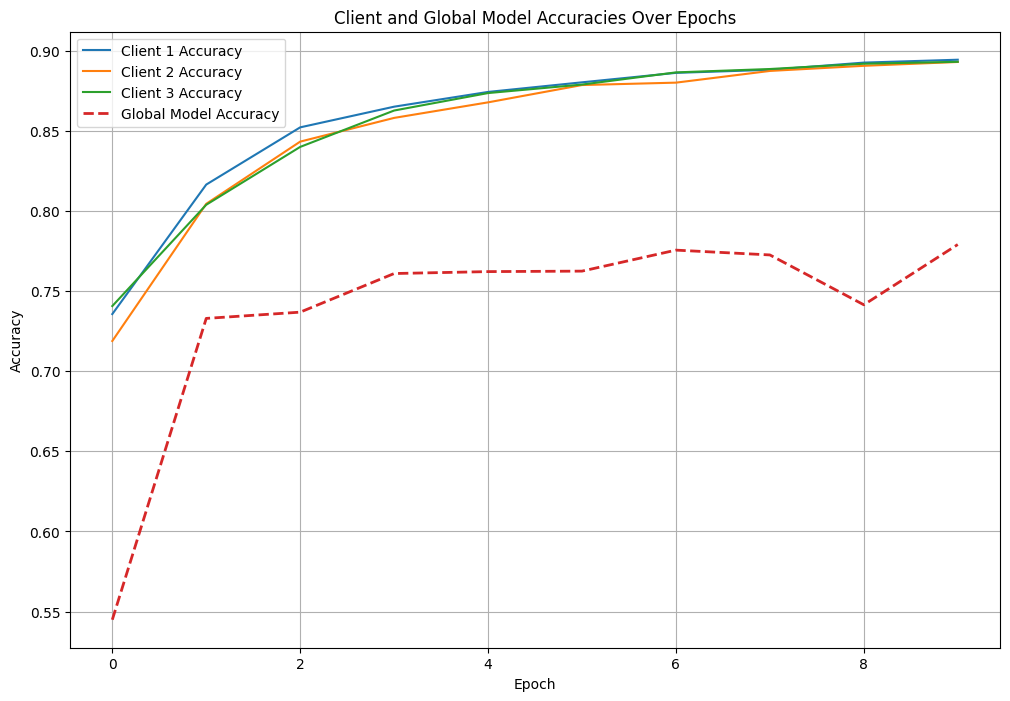

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(client_accuracies[i], label=f'Client {i+1} Accuracy')
plt.plot(global_accuracies, label='Global Model Accuracy', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Client and Global Model Accuracies Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# FedSGD

Epoch 1: Global model accuracy: 0.8438
Epoch 2: Global model accuracy: 0.8754
Epoch 3: Global model accuracy: 0.8889
Epoch 4: Global model accuracy: 0.8959
Epoch 5: Global model accuracy: 0.9025
Epoch 6: Global model accuracy: 0.9064
Epoch 7: Global model accuracy: 0.9083
Epoch 8: Global model accuracy: 0.9115
Epoch 9: Global model accuracy: 0.9140
Epoch 10: Global model accuracy: 0.9164


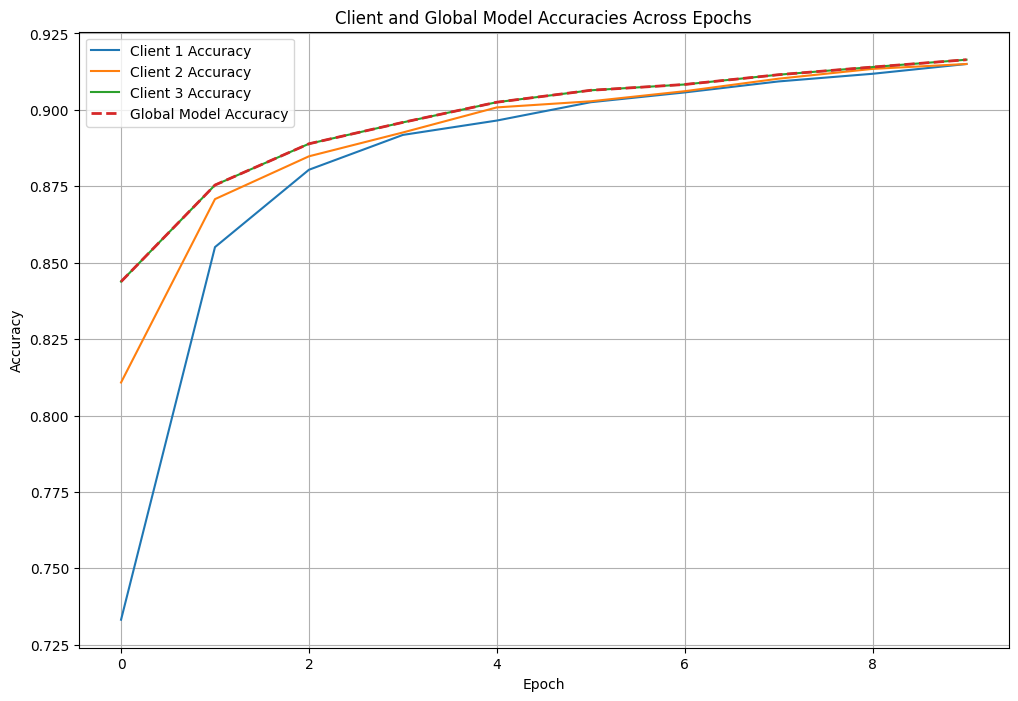

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split data for 3 clients
indices = torch.randperm(len(train_data)).tolist()
client_datasets = [Subset(train_data, indices[i::3]) for i in range(3)]
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model definition
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize global model and optimizers
global_model = SimpleMLP().to(device)
global_optimizer = optim.SGD(global_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

# Function to perform FedSGD
def fed_sgd(client_data, model, global_optimizer, criterion, device):
    global_optimizer.zero_grad()
    data, target = client_data
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    loss.backward()  # Gradients are computed here
    global_optimizer.step()  # Update using the gradients

# Evaluate function
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

# Training and evaluation
epochs = 10
global_accuracies = []
client_accuracies = [[] for _ in range(3)]

for epoch in range(epochs):
    client_loaders = [DataLoader(dataset, batch_size=64, shuffle=True) for dataset in client_datasets]
    for i, client_loader in enumerate(client_loaders):
        for client_data in client_loader:
            fed_sgd(client_data, global_model, global_optimizer, criterion, device)
        acc = evaluate(global_model, device, test_loader)
        client_accuracies[i].append(acc)
    global_acc = evaluate(global_model, device, test_loader)
    global_accuracies.append(global_acc)
    print(f'Epoch {epoch+1}: Global model accuracy: {global_acc:.4f}')

# Plot accuracies
plt.figure(figsize=(12, 8))
for i, accuracies in enumerate(client_accuracies):
    plt.plot(accuracies, label=f'Client {i+1} Accuracy')
plt.plot(global_accuracies, label='Global Model Accuracy', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Client and Global Model Accuracies Across Epochs')
plt.legend()
plt.grid(True)
plt.show()
